In [22]:
# Import packages
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [18]:
# Load Dataset 
df = pd.read_csv(r"C:\Users\diand\OneDrive - SUNTECH S.A\Desktop\Machine Learning and Predictive Modeling\Final Assignment\Temperature Data of California.csv")
df['Time'] = pd.to_datetime(df['TIME'], format='%Y-%m')
df = df.sort_values(['County', 'Time']).reset_index(drop=True)

df.head()

,County,TIME,Mean_Temperature,Time
0,Alameda,1981-01,9.869529,1981-01-01
1,Alameda,1981-02,11.723992,1981-02-01
2,Alameda,1981-03,11.615960,1981-03-01
3,Alameda,1981-04,14.036708,1981-04-01
4,Alameda,1981-05,16.333115,1981-05-01


C:\Users\diand\AppData\Local\Temp\ipykernel_38460\724223970.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


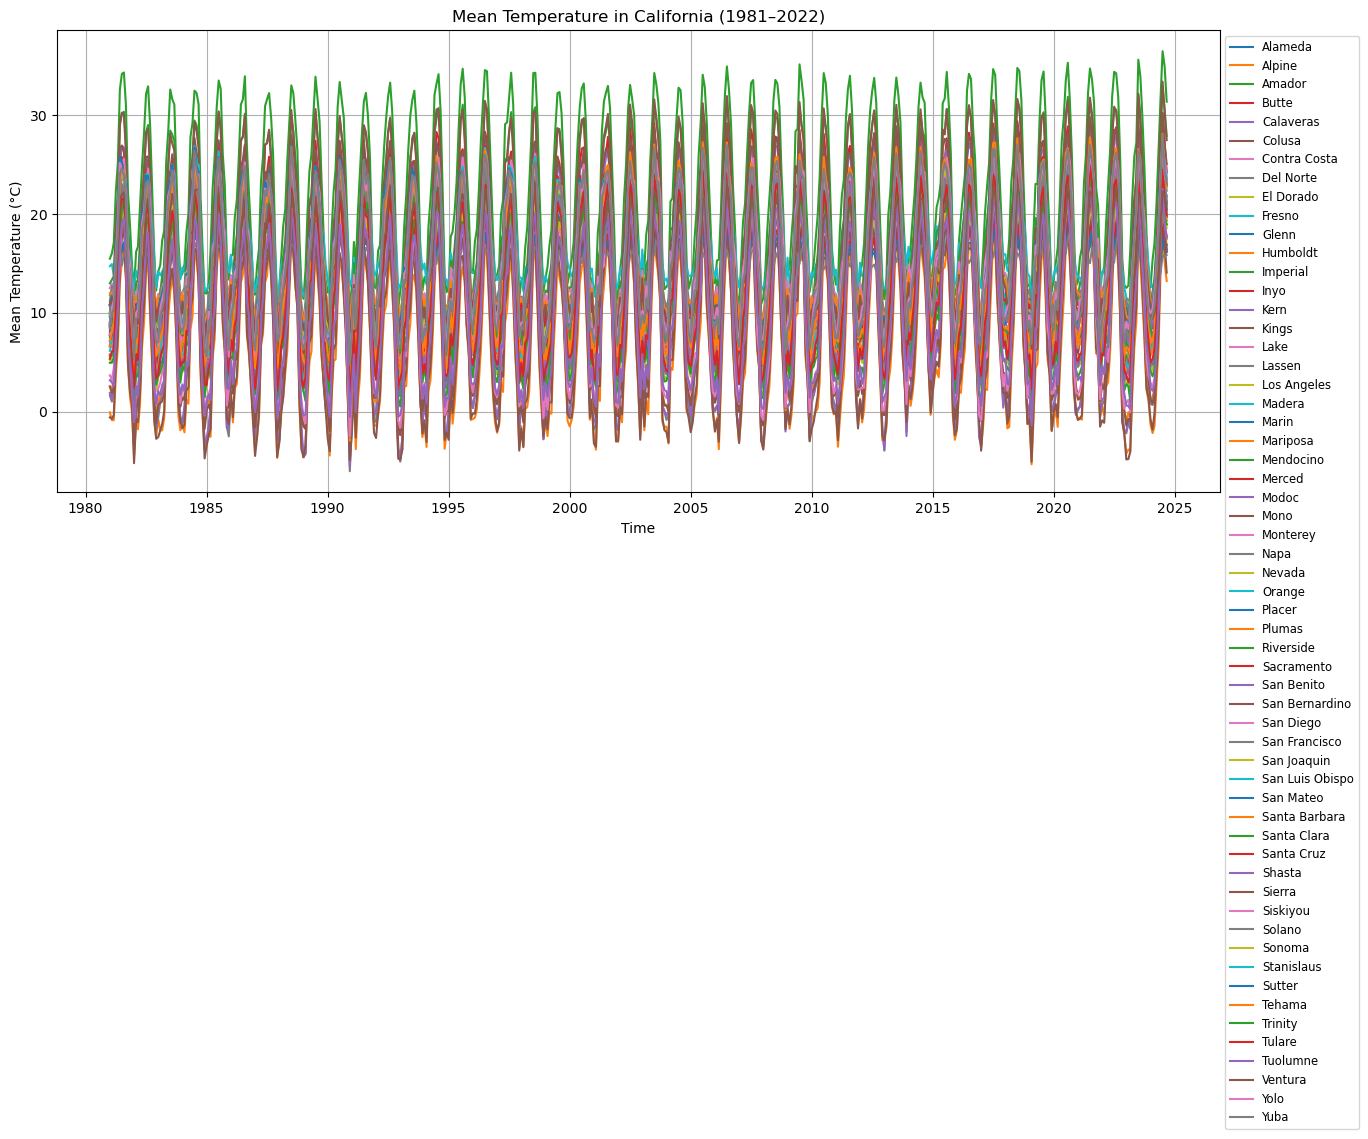

In [21]:
plt.figure(figsize=(15, 6))

for county in df['County'].unique():
    county_df = df[df['County'] == county]
    plt.plot(county_df['Time'], county_df['Mean_Temperature'], label=county)

plt.title('Mean Temperature in California (1981–2022)')
plt.xlabel('Time')
plt.ylabel('Mean Temperature (°C)')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), ncol=1, fontsize='small')  # Adjusted legend placement
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# Parameters
SEQ_LEN = 48
EPOCHS = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_forecasts = []

In [12]:
# Sequence Creation
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        xs.append(data[i:i+seq_len])
        ys.append(data[i+seq_len])
    return np.array(xs), np.array(ys)

In [13]:
# ─── TCN Components
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        self.net = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding, dilation=dilation),
            Chomp1d(padding),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=3):
        super().__init__()
        layers = []
        for i in range(len(num_channels)):
            in_ch = input_size if i == 0 else num_channels[i-1]
            out_ch = num_channels[i]
            dilation = 2 ** i
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, dilation))
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)
    def forward(self, x):
        y = self.network(x)
        return self.linear(y[:, :, -1])

In [14]:
# Forecast Loop
for county in tqdm(df['County'].unique(), desc="Processing counties"):
    county_df = df[df['County'] == county].copy()
    county_df = county_df.sort_values('Time').reset_index(drop=True)

    if len(county_df) < SEQ_LEN + 12:
        print(f"Skipping {county}: insufficient data")
        continue

    # Normalize
    scaler = MinMaxScaler()
    county_df['ScaledTemp'] = scaler.fit_transform(county_df[['Mean_Temperature']])

    # Train-test split (first 70% for training)
    total = len(county_df)
    split_idx = int(0.7 * total)
    train_vals = county_df['ScaledTemp'].iloc[:split_idx].values
    test_vals = county_df['ScaledTemp'].iloc[split_idx - SEQ_LEN:].values  # include overlap

    # Sequence data
    X_np, y_np = create_sequences(train_vals, SEQ_LEN)
    X = torch.tensor(X_np, dtype=torch.float32).unsqueeze(1).to(device)
    y = torch.tensor(y_np, dtype=torch.float32).to(device)

    # Model setup
    model = TCN(1, 1, [16, 32, 32, 32]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    for epoch in range(EPOCHS):
        model.train()
        optimizer.zero_grad()
        pred = model(X).squeeze()
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

    # Forecasting on test portion
    model.eval()
    forecast_input = torch.tensor(test_vals[:SEQ_LEN], dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    predictions = []

    for _ in range(len(test_vals) - SEQ_LEN):
        with torch.no_grad():
            out = model(forecast_input)
            predictions.append(out.item())
            forecast_input = torch.cat([forecast_input[:, :, 1:], out.view(1, 1, 1)], dim=2)

    # Build forecast DataFrame
    forecast_temp = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    forecast_time = county_df['Time'].iloc[split_idx:].values[:len(forecast_temp)]
    forecast_df = pd.DataFrame({
        'County': county,
        'Time': forecast_time,
        'Predicted_Temp': forecast_temp.flatten()
    })

    # Merge with original
    actuals = county_df[['Time', 'Mean_Temperature']]
    result = actuals.merge(forecast_df, on='Time', how='left')
    result['County'] = county
    all_forecasts.append(result)

Processing counties: 100%|██████████| 58/58 [05:26<00:00,  5.62s/it]


In [15]:
# Save Results
result_df = pd.concat(all_forecasts).reset_index(drop=True)
result_df.to_csv("TCN_Temp_Forecast_Full_1981_2022_SEQ60.csv", index=False)
print("Forecasting complete. Output saved as TCN_Temp_Forecast_Full_1981_2022_SEQ60.csv")

Forecasting complete. Output saved as TCN_Temp_Forecast_Full_1981_2022_SEQ60.csv


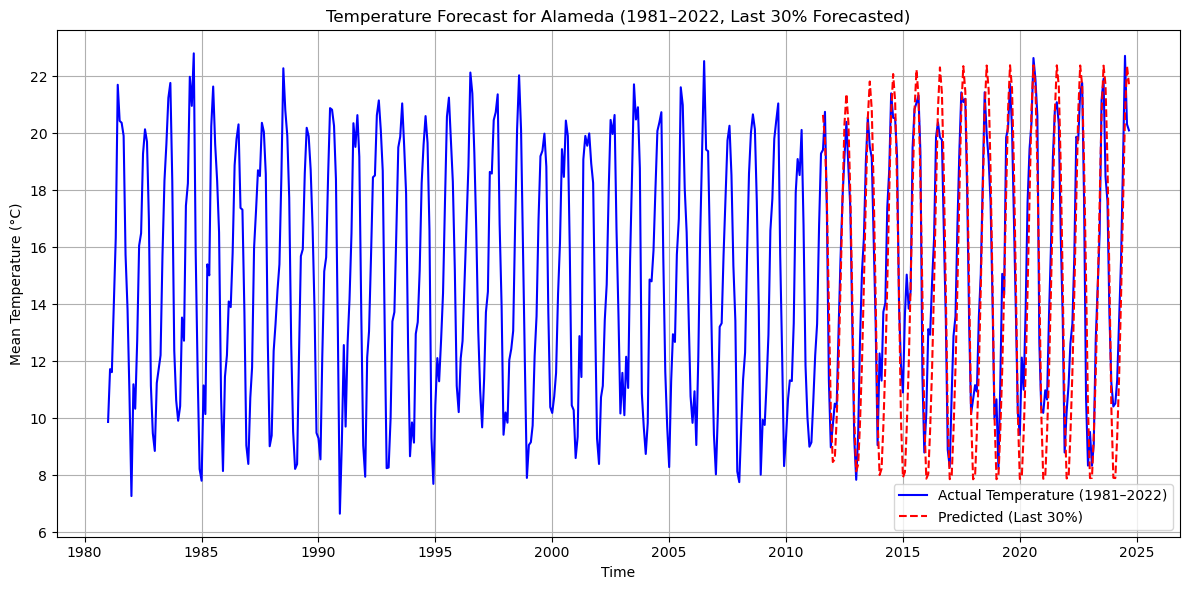

In [17]:
# Plot Example for Alameda
example_county = "Alameda"
f = result_df[result_df['County'] == example_county]

plt.figure(figsize=(12, 6))
plt.plot(f['Time'], f['Mean_Temperature'], label='Actual Temperature (1981–2022)', color='blue')
plt.plot(f['Time'], f['Predicted_Temp'], label='Predicted (Last 30%)', color='red', linestyle='--')
plt.title(f'Temperature Forecast for {example_county} (1981–2022, Last 30% Forecasted)')
plt.xlabel('Time')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
# Collect metrics per county
metrics = []

for county in result_df['County'].unique():
    county_data = result_df[result_df['County'] == county].dropna(subset=['Predicted_Temp'])

    y_true = county_data['Mean_Temperature'].values
    y_pred = county_data['Predicted_Temp'].values

    if len(y_true) == 0 or len(y_pred) == 0:
        continue

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    acc = np.mean(np.abs(y_true - y_pred) <= 2) * 100  # Accuracy within ±2°C

    metrics.append({
        'County': county,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Accuracy (±2°C)': acc
    })

# Convert to DataFrame and save
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("TCN_Temperature_Metrics_By_County.csv", index=False)

print("Metrics saved to TCN_Temperature_Metrics_By_County.csv")

Metrics saved to TCN_Temperature_Metrics_By_County.csv
